In [1]:
# !pip install kaggle
# !kaggle datasets download -p dataset/ --unzip cpanag/aifloodsense

In [2]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random
from torch import nn
from tqdm import tqdm
from torchmetrics import JaccardIndex
import albumentations as A
import cv2
import segmentation_models_pytorch as smp

/home/ilya/learning/projects/flood_segmentation/flood_segmentation/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
classes_info = pd.DataFrame({
    'class': ['background', 'flood', 'sky', 'building'],
    'grayscale_value': [0, 255, 170, 85],
    'class_index': [0, 1, 2, 3]
})

classes_info

,class,grayscale_value,class_index
0,background,0,0
1,flood,255,1
2,sky,170,2
3,building,85,3


In [5]:
TRAIN_IMAGES_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'train', 'images')
TRAIN_MASKS_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'train', 'masks')
VAL_IMAGES_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'test', 'images')
VAL_MASKS_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'test', 'masks')

In [6]:
for image_name in os.listdir(TRAIN_IMAGES_PATH):
    image_path = os.path.join(TRAIN_IMAGES_PATH, image_name)
    mask_name = image_name.split('.')[0] + '.png'
    mask_path = os.path.join(TRAIN_MASKS_PATH, mask_name)

image_path, mask_path

('dataset/AIFloodSense/AIFloodSense/train/images/157.jpg',
 'dataset/AIFloodSense/AIFloodSense/train/masks/157.png')

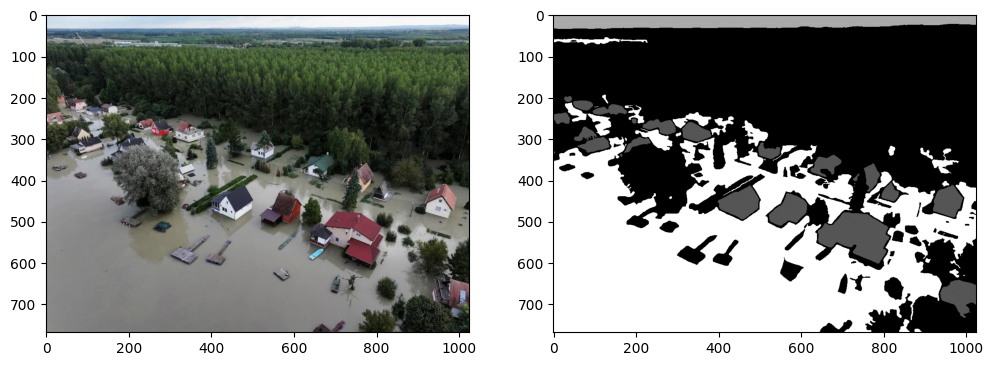

In [7]:
image = Image.open(image_path)
mask = Image.open(mask_path)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

In [8]:
mask_np = np.array(mask)
np.unique(mask_np)

array([  0,  85, 170, 255], dtype=uint8)

In [9]:
def color_to_index(mask):
    mask_indexes = []

    for color in classes_info['grayscale_value'].values:
        mask_indexes.append(torch.where(mask == color, 1, 0).tolist())

    return torch.tensor(mask_indexes).argmax(dim=0)

In [10]:
color_to_index(torch.tensor(mask_np)).unique()

tensor([0, 1, 2, 3])

In [11]:
IMAGE_SIZE = (448, 448)

train_transforms = A.Compose([
    A.Resize(*IMAGE_SIZE, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.Rotate(limit=(-10, 10), interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(*IMAGE_SIZE, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
])

In [12]:
class FloodsDataset(Dataset):
    def __init__(self, images_path, masks_path, transforms):
        super().__init__()
        self.images_pathes = []
        self.masks_pathes = []
        self.transforms = transforms

        for image_name in os.listdir(images_path):
            image_path = os.path.join(images_path, image_name)
            mask_name = image_name.split('.')[0] + '.png'
            mask_path = os.path.join(masks_path, mask_name)
            self.images_pathes.append(image_path)
            self.masks_pathes.append(mask_path)

    def __len__(self):
        return len(self.images_pathes)

    def __getitem__(self, index):
        image_path = self.images_pathes[index]
        mask_path = self.masks_pathes[index]
        image = np.array(Image.open(image_path))
        mask = np.array(Image.open(mask_path))
        transformed = self.transforms(image=image, mask=mask)
        indexed_mask = color_to_index(transformed['mask'].squeeze())
        return transformed['image'], indexed_mask

In [13]:
train_ds = FloodsDataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, train_transforms)
val_ds = FloodsDataset(VAL_IMAGES_PATH, VAL_MASKS_PATH, val_transforms)
len(train_ds), len(val_ds)

(376, 94)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


tensor([0, 1, 2, 3])


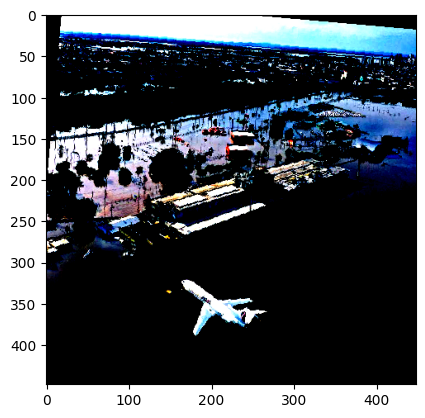

In [14]:
random_index = random.randint(0, len(train_ds) - 1)
random_image = train_ds[random_index][0]
random_mask = train_ds[random_index][1]
print(random_mask.unique())
plt.imshow(random_image.permute(1, 2, 0))


In [15]:
BATCH_SIZE = 16

train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [16]:
for batch in train_loader:
    images = batch[0]
    image_sample = images[0]
    masks = batch[1]
    mask_sample = masks[0]
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


tensor([0, 1, 3])


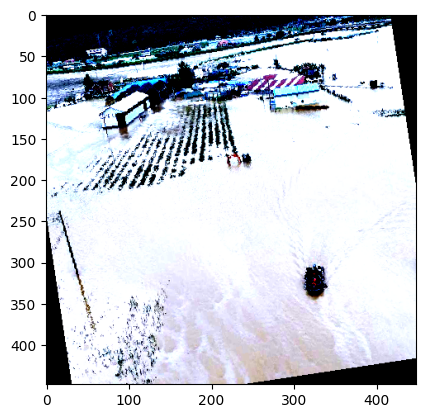

In [17]:
print(mask_sample.unique())
plt.imshow(image_sample.permute(1, 2, 0))

In [18]:
mask_sample.shape

torch.Size([448, 448])

In [19]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'
device

device(type='cuda')

In [20]:
model = smp.Unet(
    encoder_name="vgg19",
    encoder_weights="imagenet",
    in_channels=3,
    classes=len(classes_info),
)

In [21]:
model(batch[0]).shape

torch.Size([16, 4, 448, 448])

In [22]:
model.to(device)

Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
jaccard_index = JaccardIndex('multiclass', num_classes=len(classes_info)).to(device)

In [24]:
def train(model, loader, loss_fn, optimizer):
    iou_sum = 0
    loss_sum = 0

    model.train()
    for X, Y in tqdm(loader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, Y)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1)
        iou_sum += jaccard_index(pred, Y).item()
        loss_sum += loss.item()

    return iou_sum / len(loader), loss_sum / len(loader)

In [25]:
def evaluate(model, loader, loss_fn):
    iou_sum = 0
    loss_sum = 0

    model.eval()
    with torch.no_grad():
        for X, Y in tqdm(loader):
            X, Y = X.to(device), Y.to(device)
            output = model(X)
            loss = loss_fn(output, Y)
            pred = output.argmax(dim=1)
            iou_sum += jaccard_index(pred, Y).item()
            loss_sum += loss.item()

    return iou_sum / len(loader), loss_sum / len(loader)

In [26]:
EPOCHS = 20
train_losses = []
train_metrics = []
val_losses = []
val_metrics = []
min_val_loss = None

for epoch in range(1, EPOCHS + 1):
    print('-' * 10)
    print(f'Epoch {epoch}:')
    train_iou, train_loss = train(model, train_loader, loss_fn, optimizer)
    train_metrics.append(train_iou)
    train_losses.append(train_loss)
    print(f'Train IoU: {train_iou}')
    print(f'Train loss: {train_loss}')
    val_iou, val_loss = evaluate(model, val_loader, loss_fn)
    val_metrics.append(val_iou)
    val_losses.append(val_loss)
    print(f'Val IoU: {val_iou}')
    print(f'Val loss: {val_loss}')
    lr_scheduler.step(val_loss)

    if not min_val_loss or min_val_loss > val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'models/best_params.pt')
        print('Best model saved')

----------
Epoch 1:


100%|██████████| 24/24 [01:37<00:00,  4.07s/it]


Train IoU: 0.3461001232887308
Train loss: 1.1105758498112361


100%|██████████| 6/6 [00:20<00:00,  3.49s/it]


Val IoU: 0.47337939341862995
Val loss: 0.8829519550005595
Best model saved
----------
Epoch 2:


100%|██████████| 24/24 [01:36<00:00,  4.02s/it]


Train IoU: 0.5783889790376028
Train loss: 0.6927236492435137


100%|██████████| 6/6 [00:21<00:00,  3.51s/it]


Val IoU: 0.5496592223644257
Val loss: 0.852471649646759
Best model saved
----------
Epoch 3:


100%|██████████| 24/24 [01:36<00:00,  4.02s/it]


Train IoU: 0.6724444876114527
Train loss: 0.5411710627377033


100%|██████████| 6/6 [00:20<00:00,  3.48s/it]


Val IoU: 0.6666811108589172
Val loss: 0.5764086345831553
Best model saved
----------
Epoch 4:


100%|██████████| 24/24 [01:35<00:00,  3.98s/it]


Train IoU: 0.736166462302208
Train loss: 0.45411817108591396


100%|██████████| 6/6 [00:20<00:00,  3.47s/it]


Val IoU: 0.703492005666097
Val loss: 0.5191270758708318
Best model saved
----------
Epoch 5:


100%|██████████| 24/24 [01:35<00:00,  3.96s/it]


Train IoU: 0.7706641877690951
Train loss: 0.40201285605629283


100%|██████████| 6/6 [00:20<00:00,  3.48s/it]


Val IoU: 0.7355524599552155
Val loss: 0.47137897710005444
Best model saved
----------
Epoch 6:


100%|██████████| 24/24 [01:35<00:00,  3.98s/it]


Train IoU: 0.7845125546058019
Train loss: 0.3614966856936614


100%|██████████| 6/6 [00:20<00:00,  3.47s/it]


Val IoU: 0.7383207480112711
Val loss: 0.4582584500312805
Best model saved
----------
Epoch 7:


100%|██████████| 24/24 [01:36<00:00,  4.03s/it]


Train IoU: 0.8049899439016978
Train loss: 0.3290691450238228


100%|██████████| 6/6 [00:21<00:00,  3.52s/it]


Val IoU: 0.7560938596725464
Val loss: 0.4222915122906367
Best model saved
----------
Epoch 8:


100%|██████████| 24/24 [01:34<00:00,  3.96s/it]


Train IoU: 0.8061600799361864
Train loss: 0.30680645257234573


100%|██████████| 6/6 [00:21<00:00,  3.53s/it]


Val IoU: 0.7593106925487518
Val loss: 0.39625181754430133
Best model saved
----------
Epoch 9:


100%|██████████| 24/24 [01:35<00:00,  3.98s/it]


Train IoU: 0.8179350420832634
Train loss: 0.286965724080801


100%|██████████| 6/6 [00:21<00:00,  3.51s/it]


Val IoU: 0.7462126115957896
Val loss: 0.41034239033857983
----------
Epoch 10:


100%|██████████| 24/24 [01:35<00:00,  3.97s/it]


Train IoU: 0.8325000753005346
Train loss: 0.26511648794015247


100%|██████████| 6/6 [00:20<00:00,  3.47s/it]


Val IoU: 0.7771592934926351
Val loss: 0.36832937101523083
Best model saved
----------
Epoch 11:


100%|██████████| 24/24 [01:35<00:00,  3.96s/it]


Train IoU: 0.8364526579777399
Train loss: 0.25210852175951004


100%|██████████| 6/6 [00:21<00:00,  3.52s/it]


Val IoU: 0.7624708215395609
Val loss: 0.39942162732283276
----------
Epoch 12:


100%|██████████| 24/24 [01:34<00:00,  3.95s/it]


Train IoU: 0.8506109366814295
Train loss: 0.23261085773507753


100%|██████████| 6/6 [00:20<00:00,  3.46s/it]


Val IoU: 0.7821933031082153
Val loss: 0.3543753921985626
Best model saved
----------
Epoch 13:


100%|██████████| 24/24 [01:35<00:00,  4.00s/it]


Train IoU: 0.8433326979478201
Train loss: 0.23403583591183028


100%|██████████| 6/6 [00:20<00:00,  3.47s/it]


Val IoU: 0.7818375130494436
Val loss: 0.35276811321576435
Best model saved
----------
Epoch 14:


100%|██████████| 24/24 [01:35<00:00,  4.00s/it]


Train IoU: 0.8518456344803175
Train loss: 0.21881095878779888


100%|██████████| 6/6 [00:20<00:00,  3.45s/it]


Val IoU: 0.7836577395598093
Val loss: 0.3456532259782155
Best model saved
----------
Epoch 15:


100%|██████████| 24/24 [01:35<00:00,  4.00s/it]


Train IoU: 0.8594373042384783
Train loss: 0.2089620710661014


100%|██████████| 6/6 [00:20<00:00,  3.49s/it]


Val IoU: 0.7422537505626678
Val loss: 0.46481915811697644
----------
Epoch 16:


100%|██████████| 24/24 [01:35<00:00,  3.99s/it]


Train IoU: 0.8604834278424581
Train loss: 0.20648376209040484


100%|██████████| 6/6 [00:20<00:00,  3.46s/it]


Val IoU: 0.7881745298703512
Val loss: 0.3363279551267624
Best model saved
----------
Epoch 17:


100%|██████████| 24/24 [01:36<00:00,  4.00s/it]


Train IoU: 0.8667778770128886
Train loss: 0.19378478452563286


100%|██████████| 6/6 [00:20<00:00,  3.49s/it]


Val IoU: 0.7903305490811666
Val loss: 0.32979729026556015
Best model saved
----------
Epoch 18:


100%|██████████| 24/24 [01:35<00:00,  3.98s/it]


Train IoU: 0.8623497312267622
Train loss: 0.19415928112963834


100%|██████████| 6/6 [00:20<00:00,  3.49s/it]


Val IoU: 0.7904225587844849
Val loss: 0.3342381839950879
----------
Epoch 19:


100%|██████████| 24/24 [01:35<00:00,  3.96s/it]


Train IoU: 0.8634729236364365
Train loss: 0.19421538710594177


100%|██████████| 6/6 [00:20<00:00,  3.48s/it]


Val IoU: 0.7925567428270975
Val loss: 0.3227839345733325
Best model saved
----------
Epoch 20:


100%|██████████| 24/24 [01:35<00:00,  3.99s/it]


Train IoU: 0.8754923020799955
Train loss: 0.17826154455542564


100%|██████████| 6/6 [00:20<00:00,  3.46s/it]


Val IoU: 0.7979092299938202
Val loss: 0.31621481478214264
Best model saved


In [27]:
lr_scheduler.get_last_lr()

[0.0001]

Text(0.5, 1.0, "IoU's")

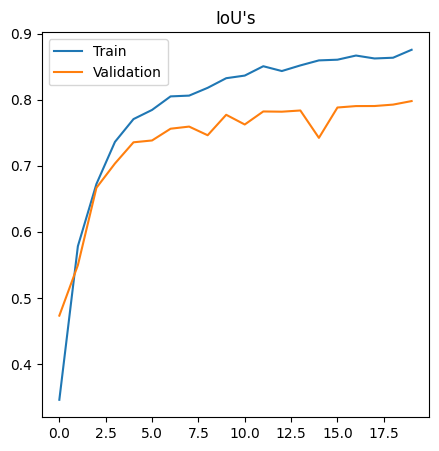

In [28]:
plt.figure(figsize=(5, 5))
plt.plot(train_metrics, label='Train')
plt.plot(val_metrics, label='Validation')
plt.legend()
plt.title('IoU\'s')

Text(0.5, 1.0, 'Losses')

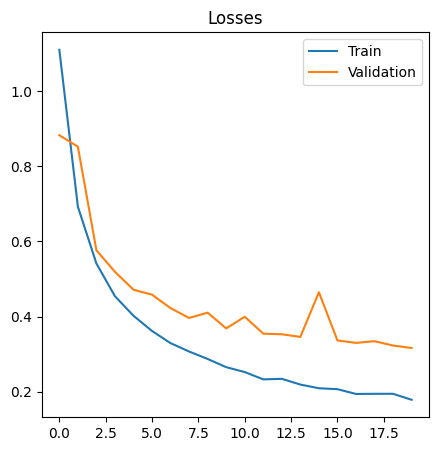

In [29]:
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.title('Losses')

In [30]:
model = smp.Unet(
    encoder_name="vgg19",
    encoder_weights=None,
    in_channels=3,
    classes=len(classes_info),
)
model.load_state_dict(torch.load('models/best_params.pt', weights_only=True))
model.eval()
model.to(device)

Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [31]:
def index_to_color(mask):
    mask_colors = []

    for index in range(len(classes_info)):
        color = classes_info[classes_info['class_index'] == index]['grayscale_value'].item()
        mask_colors.append(torch.where(mask == index, color, 0).tolist())

    return torch.tensor(mask_colors).max(dim=0).values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


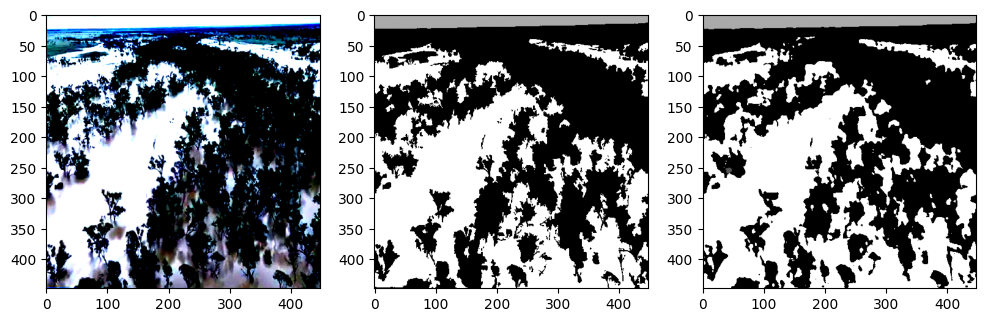

In [32]:
test_index = random.randint(0, len(val_ds) - 1)
test_image = val_ds[test_index][0]
test_mask = val_ds[test_index][1]
test_pred = model(test_image.unsqueeze(0).to(device))[0].argmax(dim=0)
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(index_to_color(test_mask), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(index_to_color(test_pred), cmap='gray')